# Import packages

In [103]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

### create function to train the model later

In [104]:
def train_and_evaluate_model(X, y):
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Convert text data into TF-IDF features
    vectorizer = TfidfVectorizer(stop_words='english')
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)

    # Train a Logistic Regression model
    model = LogisticRegression()
    model.fit(X_train_tfidf, y_train)

    # Make predictions
    y_pred = model.predict(X_test_tfidf)

    # Evaluate the model
    percentage = accuracy_score(y_test, y_pred) * 100
    formatted_percentage = f"{percentage:.2f}%"
    print("Accuracy:", formatted_percentage)
    print("Classification Report:")
    print(classification_report(y_test, y_pred))


# Read the dataset

In [105]:
df = pd.read_csv("dataset/train.csv", header=None, names=['class_index', 'review_title', 'review_text'])
df.index.name = 'review_id'

In [106]:
df.shape

(3600000, 3)

In [107]:
df = df.head(100000)
df.head()

,class_index,review_title,review_text
review_id,,,
0,2,Stuning even for the non-gamer,This sound track was beautiful! It paints the ...
1,2,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
2,2,Amazing!,This soundtrack is my favorite music of all ti...
3,2,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...
4,2,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine..."


# Try Baseline Model before clean the data

In [108]:
x = df['review_text']
y = df['class_index']

train_and_evaluate_model(x, y)

Accuracy: 85.90%
Classification Report:
              precision    recall  f1-score   support

           1       0.86      0.85      0.85     14468
           2       0.86      0.87      0.86     15532

    accuracy                           0.86     30000
   macro avg       0.86      0.86      0.86     30000
weighted avg       0.86      0.86      0.86     30000



class_index
2    51267
1    48733
Name: count, dtype: int64


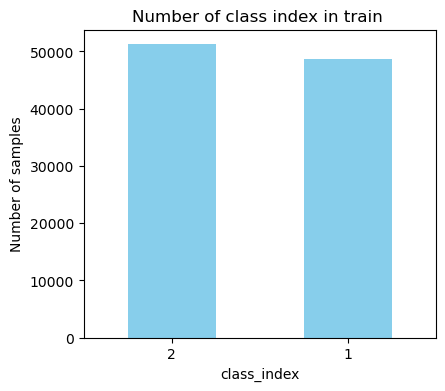

In [109]:
plt.figure(figsize=(10, 4))

train_class_index_counts = df['class_index'].value_counts()
print(train_class_index_counts)
plt.subplot(1, 2, 1)
train_class_index_counts.plot(kind='bar', color='skyblue')
plt.title('Number of class index in train ')
plt.xlabel('class_index')
plt.ylabel('Number of samples')
plt.xticks(rotation=0)


plt.show()

# Detect Missing Values

In [110]:
df[df.isnull().any(axis=1)].info()

<class 'pandas.core.frame.DataFrame'>
Index: 5 entries, 13265 to 37347
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   class_index   5 non-null      int64 
 1   review_title  0 non-null      object
 2   review_text   5 non-null      object
dtypes: int64(1), object(2)
memory usage: 160.0+ bytes


### filling the missing values

In [111]:
df['review_title'] = df['review_title'].fillna('No Title')

In [112]:
df[df.isnull().any(axis=1)].info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   class_index   0 non-null      int64 
 1   review_title  0 non-null      object
 2   review_text   0 non-null      object
dtypes: int64(1), object(2)
memory usage: 0.0+ bytes


In [113]:
df[df.duplicated()]

,class_index,review_title,review_text
review_id,,,


# Text Cleaning

### Convert Text To Lowercase

In [114]:
df[df['review_title'].str.contains(r'[A-Z]', na=False)].count()

class_index     87891
review_title    87891
review_text     87891
dtype: int64

In [115]:
# Filter rows where 'review_title' contains uppercase letters
uppercase_rows = df[df['review_title'].str.contains(r'[A-Z]', na=False)]

# Convert 'review_title' in those rows to lowercase
df.loc[uppercase_rows.index, 'review_title'] = df.loc[uppercase_rows.index, 'review_title'].str.lower()



In [116]:
df[df['review_title'].str.contains(r'[A-Z]', na=False)].count()

class_index     0
review_title    0
review_text     0
dtype: int64

In [117]:
df[df["review_text"].str.contains(r'[A-Z]', na=False)].count()

class_index     97543
review_title    97543
review_text     97543
dtype: int64

In [118]:
# Filter rows where 'review_text' contains uppercase letters
uppercase_rows = df[df['review_text'].str.contains(r'[A-Z]', na=False)]

# Convert 'review_title' in those rows to lowercase
df.loc[uppercase_rows.index, 'review_text'] = df.loc[uppercase_rows.index, 'review_title'].str.lower()

In [119]:
df[df["review_text"].str.contains(r'[A-Z]', na=False)].count()

class_index     0
review_title    0
review_text     0
dtype: int64

### work in sample example

### detect stop words and remove theme

## Get real sentiments

### Create the function

In [120]:
sia = SentimentIntensityAnalyzer()

def assign_real_class_index(text):
    sentiment = sia.polarity_scores(text)
    compound = sentiment['compound']
    if compound >= 0.05:
        return 2  # Positive sentiment
    elif compound <= -0.05:
        return 1  # Negative sentiment
    else:
        return 0  # Neutral sentiment


### Add new column

In [121]:
df['real_class_index'] = df['review_text'].apply(assign_real_class_index)
df.sample(7)

,class_index,review_title,review_text,real_class_index
review_id,,,,
15896,1,"really, all this just to sell books","really, all this just to sell books",0
3400,1,hate this printer! annoying messages to reset ...,hate this printer! annoying messages to reset ...,1
65952,2,astral projection deliver again,astral projection deliver again,0
18258,1,not happy with scale innaccurate,not happy with scale innaccurate,1
82058,2,a fascinating read...,a fascinating read...,2
29418,1,very disappointed,very disappointed,1
55692,2,fascinating,fascinating,2


In [122]:
df[df["class_index"] != df["real_class_index"]].shape

(50606, 4)

real_class_index
0    39071
2    38487
1    22442
Name: count, dtype: int64


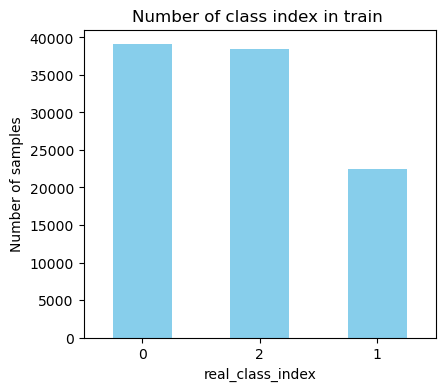

In [123]:
plt.figure(figsize=(10, 4))

train_class_index_counts = df['real_class_index'].value_counts()
print(train_class_index_counts)
plt.subplot(1, 2, 1)
train_class_index_counts.plot(kind='bar', color='skyblue')
plt.title('Number of class index in train ')
plt.xlabel('real_class_index')
plt.ylabel('Number of samples')
plt.xticks(rotation=0)


plt.show()

real_class_index
2    38487
1    22442
Name: count, dtype: int64


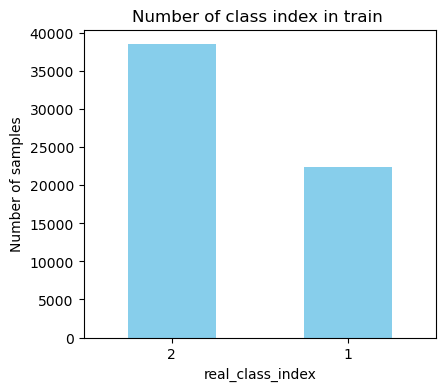

In [124]:
# Drop rows where 'real_class_index' is 0
df = df[df['real_class_index'] != 0]

plt.figure(figsize=(10, 4))

train_class_index_counts = df['real_class_index'].value_counts()
print(train_class_index_counts)
plt.subplot(1, 2, 1)
train_class_index_counts.plot(kind='bar', color='skyblue')
plt.title('Number of class index in train ')
plt.xlabel('real_class_index')
plt.ylabel('Number of samples')
plt.xticks(rotation=0)


plt.show()

# Train the model after cleaning

In [125]:
x = df['review_text']
y = df['real_class_index']

train_and_evaluate_model(x, y)

Accuracy: 89.01%
Classification Report:
              precision    recall  f1-score   support

           1       0.90      0.78      0.84      6657
           2       0.89      0.95      0.92     11622

    accuracy                           0.89     18279
   macro avg       0.89      0.87      0.88     18279
weighted avg       0.89      0.89      0.89     18279

